In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
def doublerep_pbound(p_seq, r1_seq, r2_seq,
                  p_emat, r1_emat, r2_emat, 
                  n_p, n_r1, n_r2, n_NS,
                  ep_wt=0, er1_wt=0, er2_wt=0, e_int=0,
                  gate='AND'):

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r1 = tregs.simulate.get_weight(r1_seq, r1_emat, e_wt=er1_wt)
    w_r2 = tregs.simulate.get_weight(r2_seq, r2_emat, e_wt=er2_wt)
    if gate == 'AND':
        z = 1 + n_p / n_NS * w_p + n_r1 / n_NS * w_r1 + n_r2 / n_NS * w_r2
        z += (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * np.exp(-e_int)
        pbound = (n_p / n_NS * w_p) / z
    if gate == 'OR':
        z = 1 + n_p / n_NS * w_p + n_r1 / n_NS * w_r1 + n_r2 / n_NS * w_r2
        z += (n_p / n_NS * w_p) * (n_r1 / n_NS * w_r1)
        z += (n_p / n_NS * w_p) * (n_r2 / n_NS * w_r2)
        z += (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * np.exp(-e_int)
        pbound = (n_p / n_NS * w_p + (n_p / n_NS * w_p) * (n_r1 / n_NS * w_r1) + (n_p / n_NS * w_p) * (n_r2 / n_NS * w_r2)) / z

    return pbound

In [7]:
def simrep_helper(mutants, rnap_start, rnap_end, rep1_start, rep1_end, rep2_start, rep2_end,
                  p_emat, r1_emat, r2_emat, n_p, n_r1, n_r2, n_NS, gate,
                  ep_wt=0, er1_wt=0, er2_wt=0, e_int=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        rep1_mut = mut[rep1_start:rep1_end].upper()
        rep2_mut = mut[rep2_start:rep2_end].upper()
        rv['pbound'] = doublerep_pbound(rnap_mut, rep1_mut, rep2_mut,
                                        p_emat, r1_emat, r2_emat, 
                                        n_p, n_r1, n_r2, n_NS,
                                        ep_wt=ep_wt, er1_wt=er1_wt, er2_wt=er2_wt, e_int=e_int,
                                        gate=gate)
        l_tr.append(rv)
    df_simrep = pd.DataFrame.from_records(l_tr)

    return df_simrep


def simrep(wtseq, rnap_wtseq, rep1_wtseq, rep2_wtseq, p_emat, r1_emat, r2_emat, 
           ep_wt, er1_wt, er2_wt, e_int, n_NS, n_p, n_r1, n_r2, gate,
           num_mutants=10000, mutrate=0.1, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=mutrate,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep1_start, rep1_end = tregs.seq_utils.find_binding_site(wtseq, rep1_wtseq)
    rep2_start, rep2_end = tregs.seq_utils.find_binding_site(wtseq, rep2_wtseq)

    df_simrep = simrep_helper(mutants, rnap_start, rnap_end, rep1_start, rep1_end, rep2_start, rep2_end,
                              p_emat, r1_emat, r2_emat, n_p, n_r1, n_r2, n_NS,
                              ep_wt=ep_wt, er1_wt=er1_wt, er2_wt=er2_wt, e_int=e_int, gate=gate)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1'] = 0.1 + df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(int)
    df_simrep['ct'] = df_simrep['ct_0'] + df_simrep['ct_1']

    df_simrep['ct'] = df_simrep['ct'].astype(float)
    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

In [8]:
def generate_emap(seq, fixed=False,
                  fixed_value=1,
                  max_mut_energy=0.5):
    nt_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    emat = np.zeros((4, len(seq)))
    for i,nt in enumerate(seq):
        for j in range(4):
            if j != nt_index[nt]:
                if fixed:
                    emat[j, i] = fixed_value
                else:
                    emat[j, i] = np.random.uniform(low=0.1, high=max_mut_energy)
    
    return emat

In [9]:
def plot_footprint(df, rep1_start_site, rep2_start_site,
                   outfile=None):
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    nbins = 2
    upper_bound = max(np.mean(mu_data), 1)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=0)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(rep1_start_site, rep1_start_site + 10, alpha=0.7, color='#E8B19D')
    ax.axvspan(rep2_start_site, rep2_start_site + 10, alpha=0.7, color='#E8B19D')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')


    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((rep1_start_site, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#D56C55',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(rep1_start_site + 0.5 * 10, max(footprint) * 1.2, 'R1', fontsize = 10, color = 'k',
            ha='center', va='baseline')
    
    ax.add_patch(mpl.patches.Rectangle((rep2_start_site, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#D56C55',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(rep2_start_site + 0.5 * 10, max(footprint) * 1.2, 'R2', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
rep1_site = promoter[(115-50):(115-40)]
rep2_site = promoter[(115+15):(115+25)]
r1_emat = generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = generate_emap(rep2_site, fixed=True, fixed_value=1)

changing the relative binding energies/copy numbers

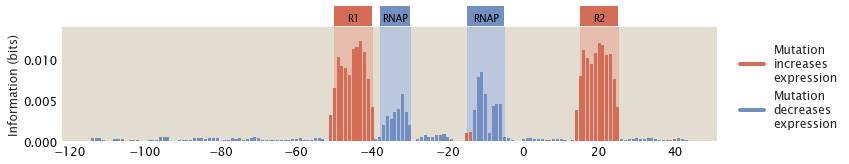

In [11]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -10
n_p, n_r1, n_r2 = 4600, 15, 15

df = simrep(promoter, rnap_site, rep1_site, rep2_site, rnap_emat, r1_emat, r2_emat, 
            ep_wt, er1_wt, er2_wt, e_int, n_NS, n_p, n_r1, n_r2, 'AND', scaling_factor=10**6)
plot_footprint(df, -50, 15)

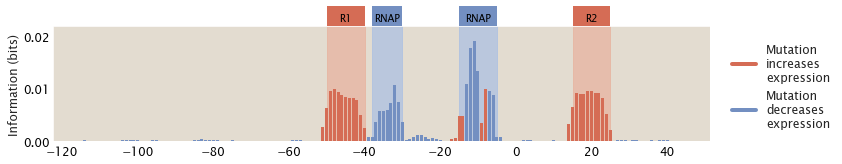

In [13]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -10
n_p, n_r1, n_r2 = 4600, 15, 15

df = simrep(promoter, rnap_site, rep1_site, rep2_site, rnap_emat, r1_emat, r2_emat, 
            ep_wt, er1_wt, er2_wt, e_int, n_NS, n_p, n_r1, n_r2, 'OR', scaling_factor=10**6)
plot_footprint(df, -50, 15,
               outfile='../../figs/higher_order_2_0.png')